In [1]:
import sys
sys.path.append('..')
import numpy as np
from src.data import jjt
from src.models.layers import MatMul, SoftmaxWithLoss, Embedding, NegativeSamplingLoss
from src.common.util import preprocess, create_contexts_target, convert_one_hot, most_similar
from src.common.trainer import Trainer
from src.common.optimizer import Adam
from src.data import jjt

GPU = False

In [2]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None
    

class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer0 = SoftmaxWithLoss()
        self.loss_layer1 = SoftmaxWithLoss()
        
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        score = self.out_layer.forward(h)
        l0 = self.loss_layer0.forward(score, contexts[:, 0])
        l1 = self.loss_layer1.forward(score, contexts[:, 1])
        loss = l0 + l1
        return loss
    
    def backward(self, dout=1):
        ds0 = self.loss_layer0.backward(dout)
        ds1 = self.loss_layer1.backward(dout)
        ds = ds0 + ds1
        da = self.out_layer.backward(ds)
        self.in_layer.backward(da)
        return None


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

| epoch 1 |  iter 1 / 119 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 119 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 119 | time 0[s] | loss 4.15
| epoch 1 |  iter 61 / 119 | time 0[s] | loss 4.11
| epoch 1 |  iter 81 / 119 | time 0[s] | loss 4.02
| epoch 1 |  iter 101 / 119 | time 1[s] | loss 3.90
| epoch 2 |  iter 1 / 119 | time 1[s] | loss 3.75
| epoch 2 |  iter 21 / 119 | time 1[s] | loss 3.58
| epoch 2 |  iter 41 / 119 | time 1[s] | loss 3.43
| epoch 2 |  iter 61 / 119 | time 2[s] | loss 3.29
| epoch 2 |  iter 81 / 119 | time 2[s] | loss 3.19
| epoch 2 |  iter 101 / 119 | time 2[s] | loss 3.09
| epoch 3 |  iter 1 / 119 | time 2[s] | loss 3.00
| epoch 3 |  iter 21 / 119 | time 3[s] | loss 2.92
| epoch 3 |  iter 41 / 119 | time 3[s] | loss 2.85
| epoch 3 |  iter 61 / 119 | time 3[s] | loss 2.82
| epoch 3 |  iter 81 / 119 | time 3[s] | loss 2.77
| epoch 3 |  iter 101 / 119 | time 4[s] | loss 2.75
| epoch 4 |  iter 1 / 119 | time 4[s] | loss 2.73
| epoch 4 |  iter 21 / 119 | tim

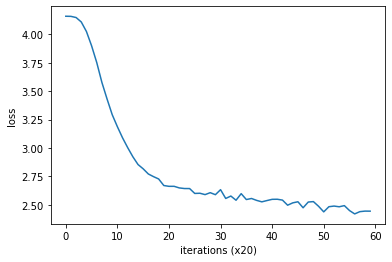

In [3]:
window_size = 3
hidden_size = 50
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = jjt.load_data()

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
#target = convert_one_hot(target, vocab_size)
#contexts = convert_one_hot(contexts, vocab_size)

model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [4]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

悪魔 [ 0.06556787  0.16228071  0.1320346  -0.14081654 -0.1750593   0.13579182
 -0.16677551 -0.14508682 -0.14482196 -0.15720907 -0.14490251  0.15183206
  0.13446349  0.1451184  -0.13359313 -0.14623246  0.15595017 -0.08435033
 -0.06106392  0.15584445 -0.1588107  -0.15141337 -0.12921466 -0.12592204
 -0.09614458  0.13327873  0.1558026   0.10652995 -0.13194627  0.12957387
 -0.12343706  0.17421392 -0.15417174 -0.14663818 -0.13069701 -0.1025674
  0.11115721  0.11524967  0.1427053  -0.12878963  0.17525908 -0.14515115
 -0.13167745  0.16182332  0.19893524  0.13337678 -0.14611652  0.14104511
 -0.11684811  0.14722416]
の [ 0.42841595  0.4660936   0.31301907 -0.23073566 -0.35468426  0.5098759
 -0.25971007 -0.294828   -0.19263221 -0.24354516 -0.39420387  0.39481688
  0.2886058   0.35309902 -0.3744442  -0.41018358  0.28427818 -0.4205844
 -0.5142568   0.3170408  -0.4303767  -0.3919197  -0.21273941 -0.42571914
 -0.31375596  0.36300793  0.34924328  0.4485881  -0.33444637  0.33616334
 -0.3641409   0.2569209

In [5]:
query = '奴'
most_similar(query, word_to_id, id_to_word, word_vecs)


[query] 奴
 盛り上がる: 0.9440534114837646
 ろうと: 0.9343657493591309
 故人: 0.9339894652366638
 寒い: 0.9332563281059265
 痛み: 0.9328320026397705
